# DNA_DNA: Deep Neural Architecture for DNA
This notebook reproduces an example of population size history inference performed by the SPIDNA deep learning method described in the paper ["Deep learning for population size history inference: design, comparison and combination with approximate Bayesian computation"](https://www.biorxiv.org/content/10.1101/2020.01.20.910539v1.full.pdf) (Sanchez et al.).

We will simulate SNP data for six scenarios with population size history defined by hand (e.g. expansion, decline or bottleneck) and use a pretrained version of SPIDNA to reconstruct these population size histories. This architecture has been trained using data generated with msprime and prior described in Sanchez et al. [methods section](https://www.biorxiv.org/content/10.1101/2020.01.20.910539v1.full.pdf#page=9). Therefore, using the same architecture to infer population size histories far from this prior might lead to high prediction errors.

## Import

In [1]:
import numpy as np
import dl.net as net_module
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import dl.utils as utils
import os
import msprime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import OrderedDict

## Simulate scenario
First, we simulate six different scenarios with 21 time steps using msprime (Kelleher et al., 2016).

In [2]:
def simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, 
                      segment_length, num_sample):
    
    demographic_events = [msprime.PopulationParametersChange(
                time=population_time[i],
                growth_rate=0,
                initial_size=population_size[i]) for i in range(1, len(population_time))]

    population_configurations = [msprime.PopulationConfiguration(
                sample_size=num_sample,
                initial_size=population_size[0])]

    tree_sequence = msprime.simulate(
                length=segment_length,
                population_configurations=population_configurations,
                demographic_events=demographic_events,
                recombination_rate=recombination_rate,
                mutation_rate=mutation_rate,
                num_replicates=num_replicates,
                random_seed=seed)
    pos = []
    snp = []
    for i, rep in enumerate(tree_sequence):
                positions = [variant.site.position for variant in rep.variants()]
                positions = np.array(positions) - np.array([0] + positions[:-1])
                positions = positions.astype(int)
                pos.append(positions)
                SNPs = rep.genotype_matrix().T.astype(np.uint8)
                snp.append(SNPs)
    data = [[snp[i], pos[i]] for i in range(len(snp))]
    data = [np.vstack([d[1], d[0]]) for d in data]
    return data

In [3]:
# Population sizes are defined on a log10 scale
scenarios = {'Medium': [3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7],   
             'Large': 4.7 * np.ones(shape=21, dtype='float'), 
             'Decline': [2.5, 2.5, 3, 3, 3, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6], 
             'Expansion': [4.7, 4.7, 4.7, 4.6, 4.6, 4.5, 4.4, 4.3, 4, 3.7, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4], 
             'Bottleneck': [4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8], 
             'Zigzag': [4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.15, 4.5, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8]}
scenarios = {k:10**np.array(scenarios[k]) for k in scenarios.keys()}
seed = 2
num_replicates = 100
mutation_rate = 1e-8
segment_length = 2e6
time_rate = 0.06
tmax = 130000
num_time_windows = 21
num_sample = 50
population_time = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows - 1)) - 1) / time_rate for i in
                  range(num_time_windows)]
snp_data = {}
for k in scenarios.keys():
    print(f'Simulating scenario \"{k}\"')
    population_size = scenarios[k]
    recombination_rate = np.random.uniform(low=1e-9, high=1e-8)
    snp_data[k] = simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, 
                             recombination_rate, segment_length, num_sample)

Simulating scenario "Medium"
Simulating scenario "Large"
Simulating scenario "Decline"
Simulating scenario "Expansion"
Simulating scenario "Bottleneck"
Simulating scenario "Zigzag"


## Load pretrained SPIDNA

In [4]:
training_param = utils.load_dict_from_json('pretrained_SPIDNA/pretrained_SPIDNA_training_param.json')
np.random.seed(training_param['seed'])
torch.manual_seed(training_param['seed'])
num_output = len(training_param['param_to_learn'])

# Set specified GPU
device = torch.device('cuda' if torch.cuda.is_available() and training_param['use_cuda'] else 'cpu')
if device.type == 'cuda' and training_param['cuda_device'] is not None:
    torch.cuda.set_device(training_param['cuda_device'])
net = getattr(net_module, training_param['network_name'])
net_param = {'num_output': num_output,
             'num_block': training_param['num_block'],
             'num_feature': training_param['num_feature'],
             'device':device}
net = net(**net_param).to(device)
if device.type == 'cpu':
    state_dict = torch.load(os.path.join(training_param['network_path']), map_location=torch.device('cpu'))
else:
    state_dict = torch.load(os.path.join(training_param['network_path']))

# Create new OrderedDict that does not contain `module.`
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)

# Dispatch mini-batch on multiple GPUs
if device.type == 'cuda':
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))

## Inference

In [5]:
net.eval()
predictions = pd.DataFrame()
with torch.no_grad():
    for scenario in snp_data.keys():
        all_output = torch.Tensor()
        for inputs in snp_data[scenario]:
            inputs = torch.Tensor(inputs[:, :training_param['SNP_min']]).to(device).unsqueeze(0)
            output = net(inputs).cpu()
            all_output = torch.cat((all_output, output), 0)
        pred = pd.DataFrame(all_output.numpy())
        pred['scenario_name'] = scenario
        predictions = pd.concat([predictions, pred])

## Plot

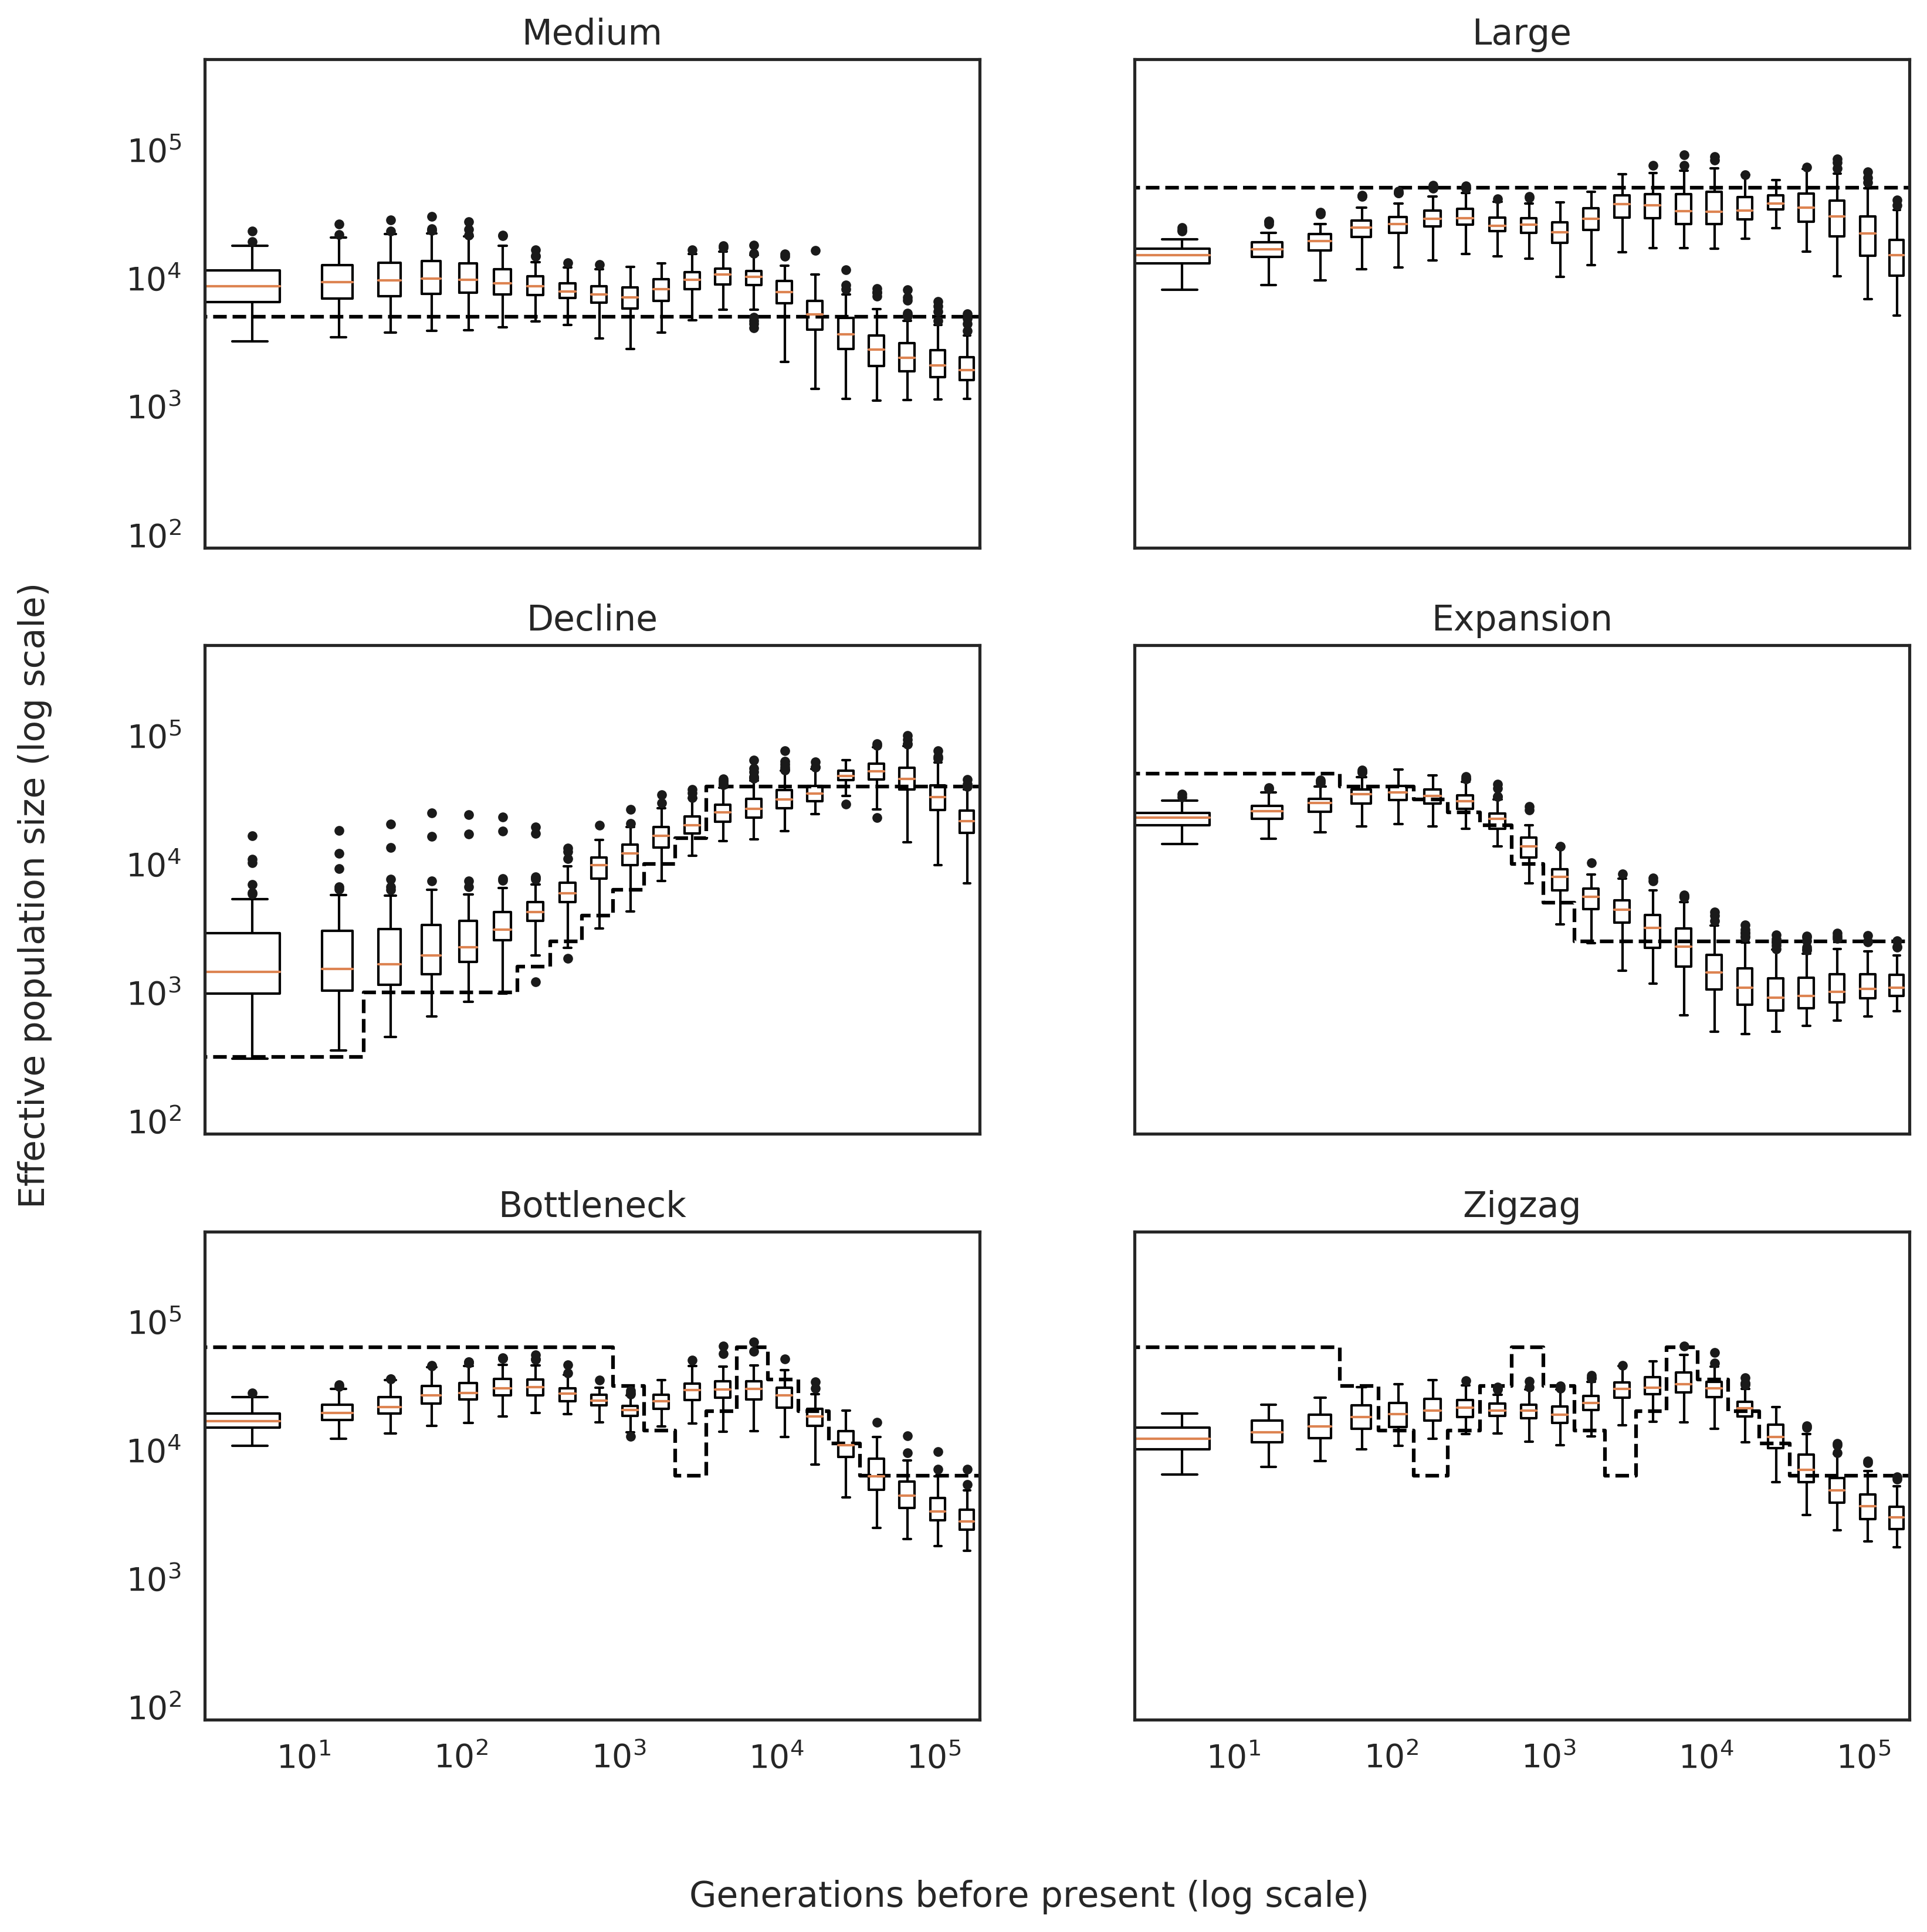

In [7]:
sns.set(style="white",font_scale=1.2)
fig = plt.figure(dpi=300, figsize=(15/1.2, 15/1.2))

# Add one step which represents the infinite time
population_time1 = np.append(population_time, population_time[-1]*1.5)
train_std = np.array([training_param['train_std'][k] for k in training_param['train_std'].keys()])
train_mean = np.array([training_param['train_mean'][k] for k in training_param['train_mean'].keys()])

axs = []
i=1
for key in scenarios.keys():
    axs.append(fig.add_subplot(3, 2, i))
    
    population_size = np.append(np.array(scenarios[key]), scenarios[key][-1])
    ax = sns.lineplot(x=population_time1, y=population_size, drawstyle='steps-post', color=(0,0,0))
    ax.lines[0].set_linestyle("--")
    
    population_time2 = np.append(np.array(population_time1), 0)
    boxplot_widths = (population_time2[1:] - population_time2[:-1])/2
    boxplot_widths[-1] = - boxplot_widths[-1]
    boxplot_positions = population_time2[:-1] + boxplot_widths
    dat = predictions.loc[predictions['scenario_name']==key].iloc[:, range(21)]
    dat.columns = population_time1[:-1]
    dat = np.transpose(np.exp((dat * train_std) + train_mean))
    
    plt.boxplot([dat.loc[i] for i in dat.index ], vert=True, positions=boxplot_positions[:-1],
                widths=boxplot_widths[:-1], sym='k.')
    
    plt.ylabel('')
    plt.xlabel('')
    plt.ylim(80, 5e5)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(key)
    i+=1
    
fig.text(0.5, 0.04, 'Generations before present (log scale)', ha='center')
fig.text(0.04, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
[ax.get_xaxis().set_visible(False) for ax in axs[:4]]
[ax.get_yaxis().set_visible(False) for ax in [axs[1], axs[3], axs[5]]]
[ax.margins(x=0) for ax in axs]

plt.show()